# Projeto 1 - Confiabilidade

Um sistema requer $n$ máquinas para funcionar. Elas quebram, a cada unidade de tempo (um minuto), com
probabilidade $p_0$. Para garantir o funcionamento confiável do sistema, $s$ máquinas adicionais são mantidas para
reposição. Quando uma máquina quebra, ela é substituída por uma em bom estado e enviada para reparo. O
tempo de reparo de cada máquina  ́e $t_R$ (fixo).

Deseja-se estudar a variável aleatória “tempo de colapso” do sistema, isto  ́e, o tempo $T$ que o sistema funciona
até dever ser parado porque não há $n$ máquinas disponíveis. Quanto vale $E(T)$? Qual é a distribuição de $T$?
Como depende a variável $T$ do número de máquinas reserva $s$? Mais em concreto, quantas máquinas adicionais
são necessárias para que Prob{$T < 10000$} seja menor que 1%?

Faixas sugeridas de valores: $n = 10 − 100$, $p_0 = 0.001 − 0.01$, $s = 10 − 100$.

1. Quais das perguntas acima conseguem responder analiticamente? Nos casos que possa, qual é o resultado?
2. Os resultados do simulador são consistentes com as estimações analíticas no caso $\beta = 0$?
3. No simulador, é fácil inserir a amostragem de outras variáveis aleatórias. Estudar por exemplo a variável $Z$ que
podemos chamar “tempo de alerta”, definido como o tempo em que o número de máquinas em reparação atinge
80% do valor disponível $s$ (ou outra porcentagem a escolher). Como é a distribuição de probabilidade de $Z$?
4. São $Z$ e $T$ variáveis independentes? É possível predizer em alguma medida o tempo de colapso uma vez que foi
atingido o tempo de alerta? Se uma parada ordenada do sistema requer o tempo $t_R$ , pode sugerir uma estratégia
de manejo que “garanta” chegar a parada ordenada com 99% de probabilidade?
1. É lógico que as máquinas envelheçam. A probabilidade de cada máquina de falhar pode crescer linearmente com
o tempo, seguindo $p(k) = p_0 + \beta t_{f}(k)$ onde $k$ identifica a máquina e $t_f(k)$ o tempo que ela leva em funcionamento
desde o  ́ultimo reparo. No caso de $β \ne 0$  ́e impossível realizar cálculos analíticos sobre a variável $T$. Para isto,
desenvolver um pequeno código de simulação do processo. Esse caso é mais complexo que o original, porque é
necessário armazenar informação específica para cada máquina (o tempo que leva trabalhando). Mesmo assim,
trata-se apenas de uma adequada combinação de variáveis Bernoulli que o computador sabe simular.

## Libs & Utils

In [1]:
import numpy as np
import pandas as pd
import sympy as sp
import scipy as sc
import scipy.special as scp
import scipy.stats as st
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import json
import os
from typing import List, Tuple, Callable, Dict
from collections import defaultdict
from math import ceil
import seaborn as sns

## Modelagem Analítica

Para seguir com a modelagem analítica, precisamos simplificar alguns aspectos do problema, para isso assumiremos:

1. $t_R \to \infty$
2. $\beta = 0$

A binomial negativa (desconsiderando as $s$ primeiras trials) (mesma do scipy):

$$
p_1(t; s, p) = \begin{pmatrix}t + s - 1 \\ s -1\end{pmatrix} p^{s} (1 - p)^{t}
$$

A binomial negativa (considerando as $s$ primeiras trials)

$$
p_2(t; s, p) = p_1(t-s; s, p) = \begin{pmatrix}t - 1 \\ s -1\end{pmatrix} p^{s} (1 - p)^{t - s}
$$

Importante notar que em cada ciclo do sistema, teríamos $n$ trials, então para obter a chance de falhar no $k$-ésimo ciclo, precisaríamos de:

$$
p_3(k; n, s, p) = \sum^{n}_{i = 1} p_2(n \cdot (k - 1) + i; s, p)
$$

Valor estimado:

$$
E = \frac{(s_0 + 1) (1 - p)}{p}
$$

CDF:

$$
I_{1-p}(s_0 + 1, k + 1)
$$


$I$ corresponde a função beta incompleta regularizada.

**Importante**

Para nosso problema, precisamos saber o número de trials antes da $s_0+1$ falha! 

### Analytical Utils

In [2]:
k, t, i, n, s, p = sp.symbols("k t i n s p")
neg_binomial_exp = sp.binomial(t - 1, s - 1) * (p ** s) * (1 - p) ** (t - s) # Negative Binomial
neg_binomial_exp = neg_binomial_exp.subs(s, s + 1) # Fix r to s definition
p_sum_exp = sp.Sum(neg_binomial_exp.subs(t, n * (k - 1) + i), (i, 1, n)) # Group trials in same day
neg_binomial_cdf = sp.betainc_regularized(s + 1, k + 1, 0, p)

In [3]:
def build_dist(s, p) -> st.nbinom:
    base_dist = st.nbinom(s + 1, p)
    return base_dist

def make_distribution_pdf(n, s, p):
    s += 1
    dist = st.nbinom(s, p)
    return lambda k: sum(dist.pmf(n * (k - 1) + i - s) for i in range(1, n+1))


In [4]:
def find_s_for_np(n, t, p, target=0.99, max_s=100000):
    l = 0
    r = max_s
    while l < r:
        mid = (l + r) // 2
        v = scp.betainc(mid + 1, n * t + 1, p)
        if v > target:
            l = mid + 1
        else:
            r = mid
    
    return l

In [5]:
dd = build_dist(2891, 0.006)
dd.cdf(500000)

0.9895878125672202

In [6]:
scp.betainc(2892, 500001, 0.006)

0.9895878125700108

In [7]:
neg_binomial_cdf.evalf(n=1000, subs={p: sp.Rational('0.006'), s: 2891, k: 500000}).evalf()

0.989587812567220

In [8]:
find_s_for_np(50, 10000, 0.006)

2891

## Simulação

### Simulation Utils

In [9]:
# Python-based simulator
from simulator.simulator import INF, factory_trial, multiple_trials

datasets_path = './datasets/'

# Load simulations from dir
def load_sims(dir_name):
    target_dir = os.path.join(datasets_path, dir_name)
    sims = []
    for target in os.listdir(target_dir):
        target_path = os.path.join(target_dir, target)
        if not os.path.isfile(target_path):
            continue

        if target.endswith('.json'):
            with open(target_path, 'r') as fp:
                sims.append(json.load(fp))

    return sims


# Generate PDF Dict from Simulation Results
def sim_pdf(results: List[int]):
    counts = defaultdict(lambda: 0)
    for r in results:
        counts[r] += 1
    return {k: v/len(results) for k, v in sorted(counts.items())}


# Plot Simulation Results PDF
def plot_trial(results: List[int], interpolate: bool = False, *args, **kwargs):
    pdf = sim_pdf(results)

    x = list(pdf.keys())
    y = list(pdf.values())

    if interpolate:
        cubic_interpolation = interp1d(x, y, kind="cubic")

        x = np.linspace(x[0], x[-1], 500)
        y = cubic_interpolation(x)
        y[y < 0] = 0
    
    return plt.plot(x, y, *args, **kwargs)

### Result Utils

In [10]:
def compare_models(x_range: Tuple[int, int], pdf: Callable[[int], float], sims: List[Dict], pdf_z: Callable[[int], float] = None, pdf_delta: Callable[[int], float] = None, sim_z: bool = True, sim_delta: bool = True, interpolate_pdf: bool = True, interpolate_sims: bool = True):
    plt.figure(figsize=(18,10))
    plt.xlim(x_range)

    # Plot Simulations
    for i, sim_data in enumerate(sims):
        plot_trial(sim_data['results'], label=f"Simulation {i+1}", linestyle="--", interpolate=interpolate_sims)

    # Plot Z
    if sim_z:
        for i, sim_data in enumerate(sims):
            plot_trial(sim_data['results_z'], label=f"Simulation Z {i+1}", linestyle="--", interpolate=interpolate_sims)
        if sim_delta:
            for i, sim_data in enumerate(sims):
                plot_trial([a - b for a, b in zip(sim_data['results'], sim_data['results_z'])], label=f"Simulation Delta {i+1}", linestyle="--", interpolate=interpolate_sims)

    # Plot Analytical Model
    x = list(range(x_range[0], x_range[1] + 1))
    y = [pdf(i) for i in x]

    if interpolate_pdf:
        cubic_interpolation = interp1d(x, y, kind="cubic")

        x = np.linspace(x[0], x[-1], 500)
        y = cubic_interpolation(x)

    plt.plot(x, y, label="Analytical Model", linestyle="-", color="#ff1493", lw=2)

    # Plot Analytical Model Z
    if pdf_z is not None:
        x = list(range(x_range[0], x_range[1] + 1))
        y = [pdf_z(i) for i in x]

        if interpolate_pdf:
            cubic_interpolation = interp1d(x, y, kind="cubic")

            x = np.linspace(x[0], x[-1], 500)
            y = cubic_interpolation(x)

        plt.plot(x, y, label="Analytical Model Z", linestyle="-", color="#194a8d", lw=2)

    if pdf_delta is not None:
        x = list(range(x_range[0], x_range[1] + 1))
        y = [pdf_delta(i) for i in x]

        if interpolate_pdf:
            cubic_interpolation = interp1d(x, y, kind="cubic")

            x = np.linspace(x[0], x[-1], 500)
            y = cubic_interpolation(x)

        plt.plot(x, y, label="Analytical Model Delta", linestyle="-", color="#b676b1", lw=2)

    plt.legend()
    plt.show()

### Resultados para $n=50$, $s=10$, $p=0.006$

In [11]:
s0 = 10
s0_z = ceil(10 * 0.8)
s0_delta = s0 - s0_z - 1

pdf_50_0006_10 = make_distribution_pdf(50, s0, 0.006) # Analytical PDF
pdf_50_0006_10_z = make_distribution_pdf(50, s0_z, 0.006) # Analytical PDF
pdf_50_0006_10_delta = make_distribution_pdf(50, s0_delta, 0.006) # Analytical PDF
sims_50_0006_10 = load_sims('50-0_006-10') # Simulation Results

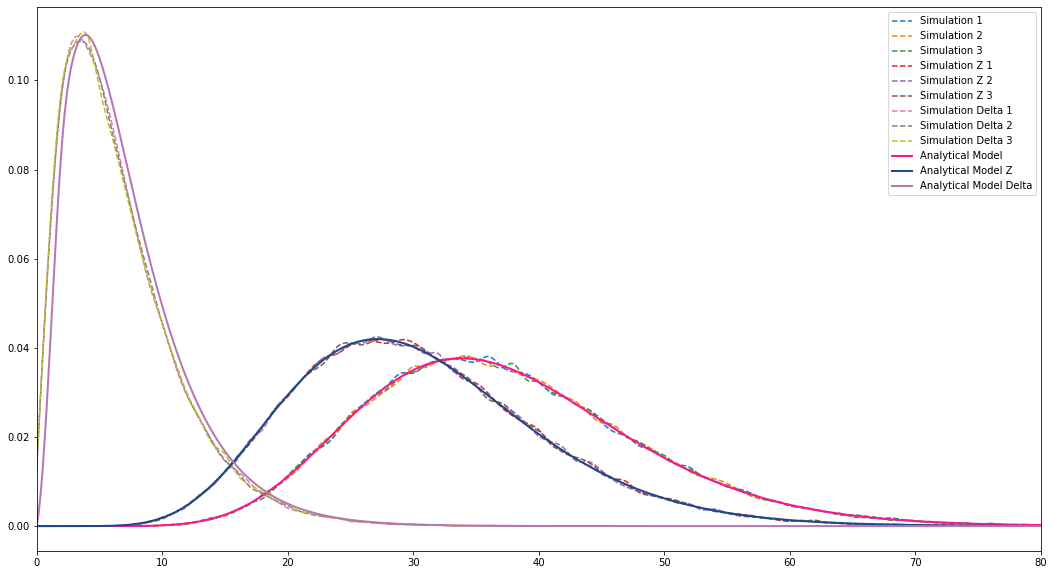

In [12]:
compare_models((0, 80), pdf_50_0006_10, sims_50_0006_10, pdf_50_0006_10_z, pdf_50_0006_10_delta)

In [13]:
print(f'P(T < 10000) <= 1%: s = {find_s_for_np(50, 10000, 0.006)}')

P(T < 10000) <= 1%: s = 2891


### Resultados para $n=100$, $s=25$, $p=0.01$

In [14]:
s0 = 25
s0_z = ceil(25 * 0.8)
s0_delta = s0 - s0_z - 1

pdf_100_001_25 = make_distribution_pdf(100, s0, 0.01) # Analytical PDF
pdf_100_001_25_z = make_distribution_pdf(100, s0_z, 0.01) # Analytical PDF
pdf_100_001_25_delta = make_distribution_pdf(100, s0_delta, 0.01)
sims_100_001_25 = load_sims('100-0_01-25') # Simulation Results

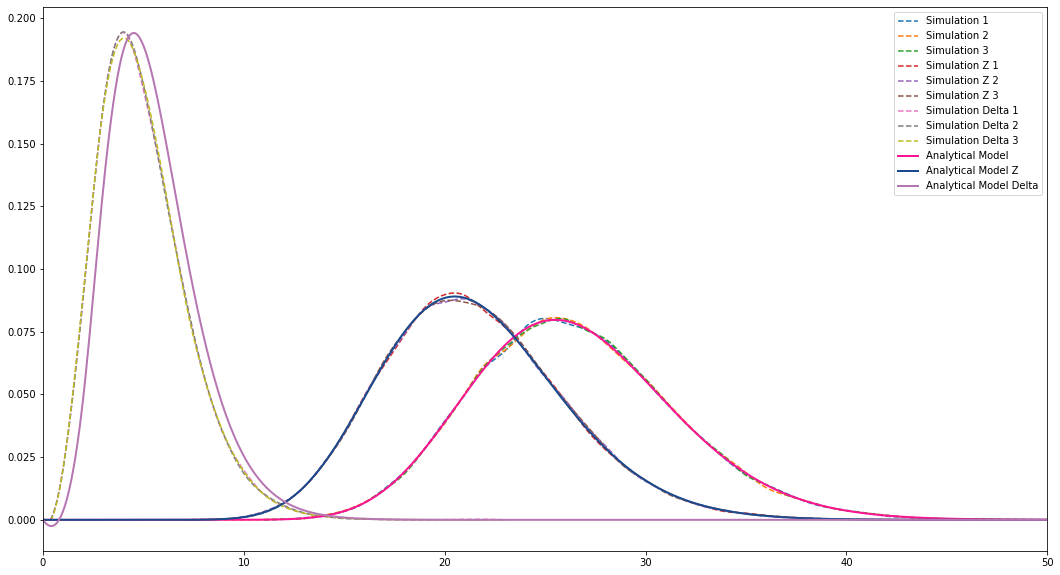

In [15]:
compare_models((0, 50), pdf_100_001_25, sims_100_001_25, pdf_100_001_25_z, pdf_100_001_25_delta)

In [16]:
print(f'P(T < 10000) <= 1%: s = {find_s_for_np(100, 10000, 0.01)}')

P(T < 10000) <= 1%: s = 9867


## Resposta 1

Dadas as restrições $\beta = 0$ e $t_R \to \infty$, podemos criar sim um modelo analítico para o problema.

Dadas essas restrições, podemos observar que nosso problema se aproxima bastante da proposta da binomial
negativa: saber a probabilidade de se precisar de $k$ testes para obter dado número fixo $r$ de sucessos.

No nosso caso, podemos observar que a condição de falha crítica do sistema, como não tem recuperação de máquinas,
é obter a $s_0 + 1$ quebra (ou seja, esgotar as máquinas reservas e quebrar mais uma). Um detalhe importante a se
observar é que, para aplicar o modelo estaremos considerando cada quebra de uma máquina como um sucesso.

Ainda assim, nos deparamos com um problema: nossa variável $T$ refere-se ao tempo gasto para um sistema com $n$
máquinas ativas em paralelo entrar em um estado crítico. Para adequar a binomial negativa a esse caso, podemos 
fazê-la como se tivéssemos as máquinas testadas de maneira sequencial, então agrupamos os resultados em grupos
de tamanho $n$, dessa forma cada grupo desses terá $n$ testes que irão representar uma unidade de tempo.

A PMF da nossa binomial negativa em função das variáveis do enunciado ficará, por fim, assim:

$$
f(k; \; n, s_0, p_0) = \sum^{n}_{i = 1} g(n \cdot (k - 1) + i; \; s_0 + 1, p_0)
$$

Onde $g$ seria a binomial negativa antes do agrupamento e deslocamento do número de sucessos:

$$
g(t; \; s, p) = \begin{pmatrix}t - 1 \\ s -1\end{pmatrix} p^{s} (1 - p)^{t - s}
$$

Para o cálculo da esperança podemos seguir a fórmula da própria binomial negativa (importante se atentar ao fato
de que o resultado será o total de testes esperado, não de unidades de tempo):

$$
E = \frac{r(1-p)}{p}
$$

Substituindo com as variáveis do problema, teremos:

$$
E = \frac{(s_0 + 1) (1 - p)}{p}
$$

Para obter o valor de $s_0$ para que $P(T > 10000) \le 1%$, podemos usar a CDF da binomial negativa. A CDF da 
binomial negativa é dada pela função beta regularizada incompleta. No caso, usamos a implementação já presente
no `scipy` para fazermos a busca do valor.

## Resposta 2

Sim, condiz.

## Resposta 3

A distribuição de $Z$ também segue a mesma binomial negativa, a única diferença é que o parâmetro $s_0$ passa ser 80% do da distribuição de $T$ (arredondado para cima).

## Resposta 4



In [17]:
np.cov(sims_100_001_25[1]['results'], sims_100_001_25[1]['results_z'])[0][1]

20.792505068550682

In [18]:
np.cov(sims_50_0006_10[1]['results'], sims_50_0006_10[1]['results_z'])[0][1]

99.33605964449642

## Resposta 5

In [19]:

demo_sims = load_sims("demos")

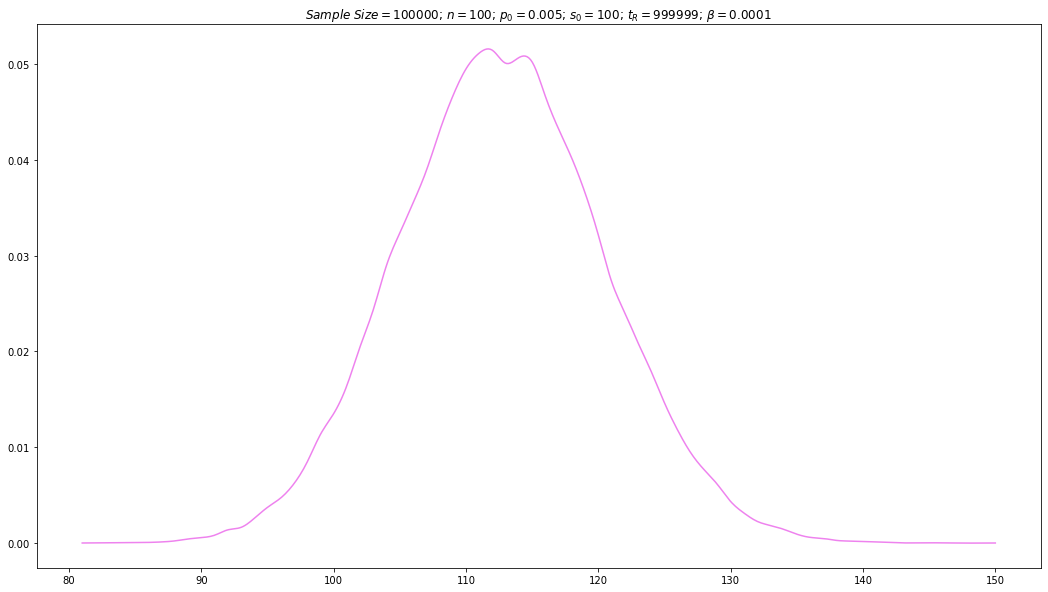

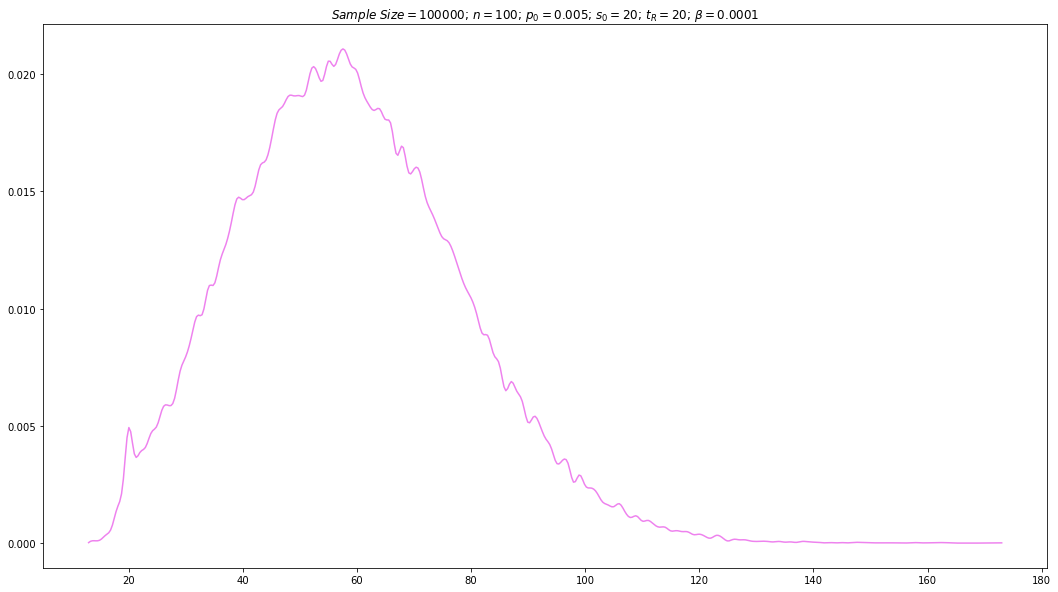

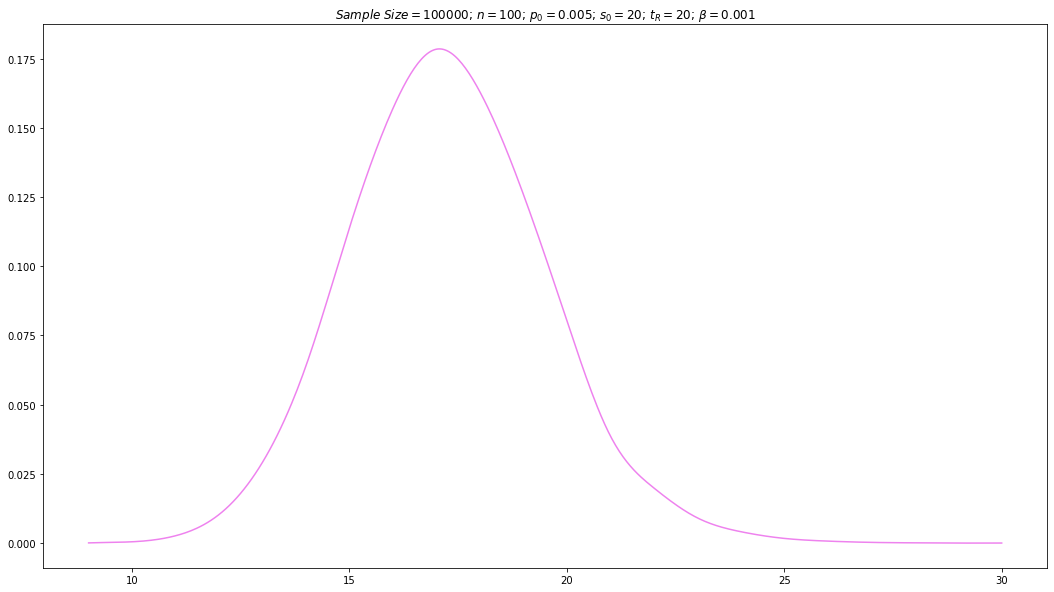

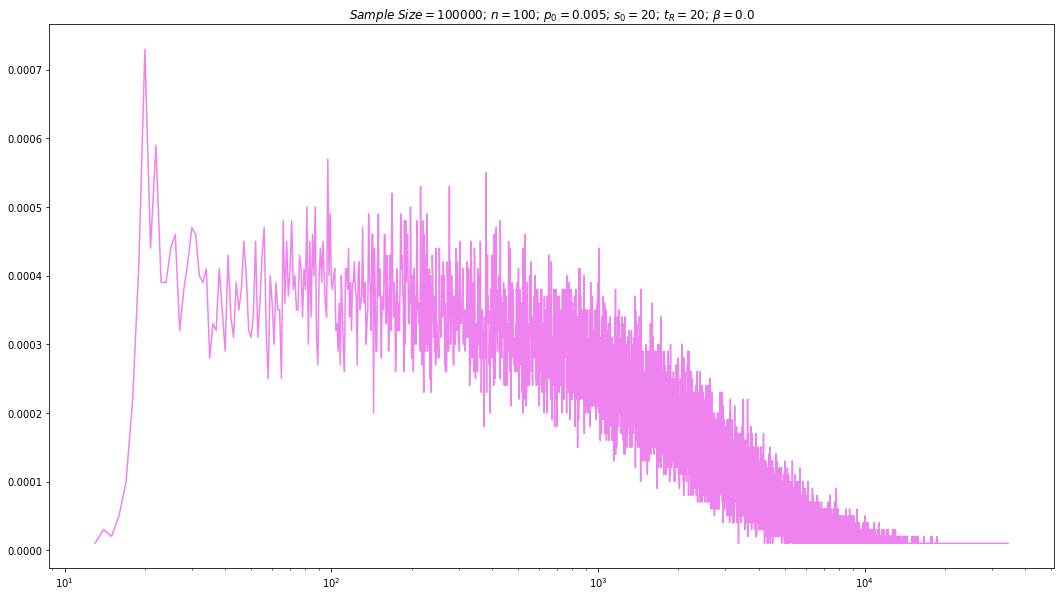

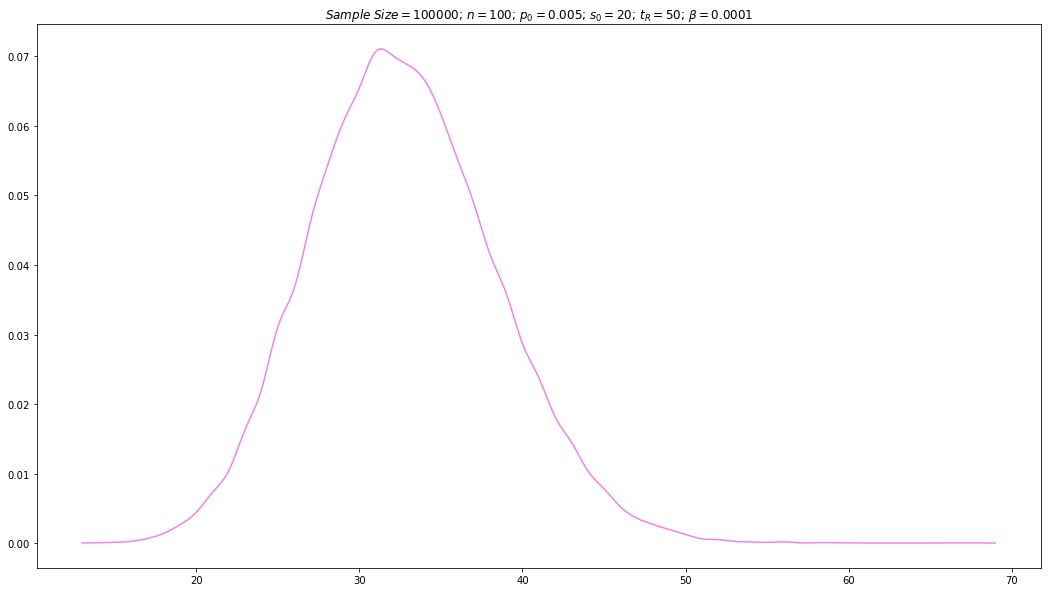

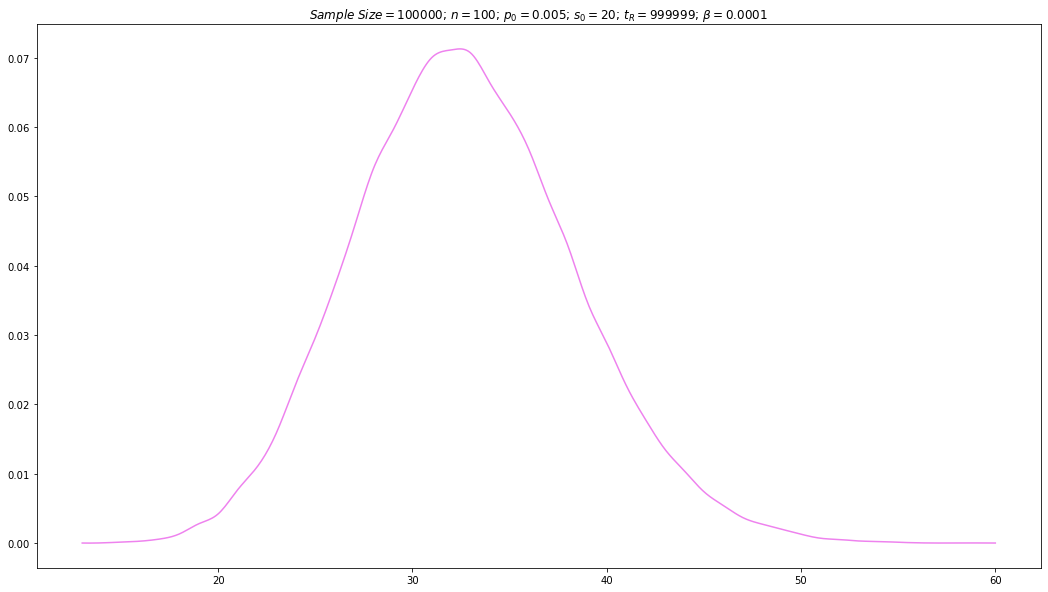

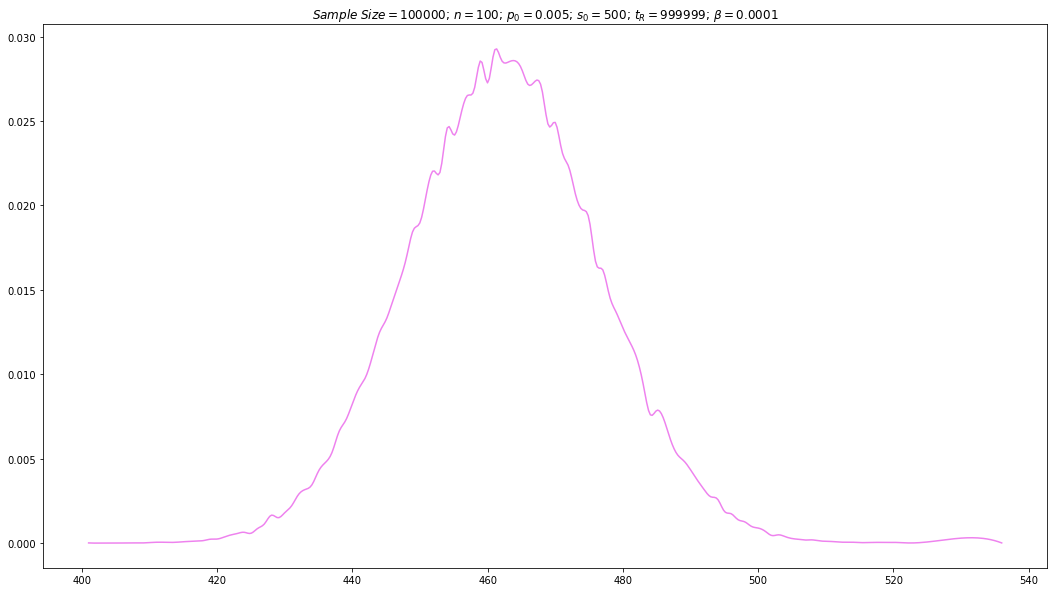

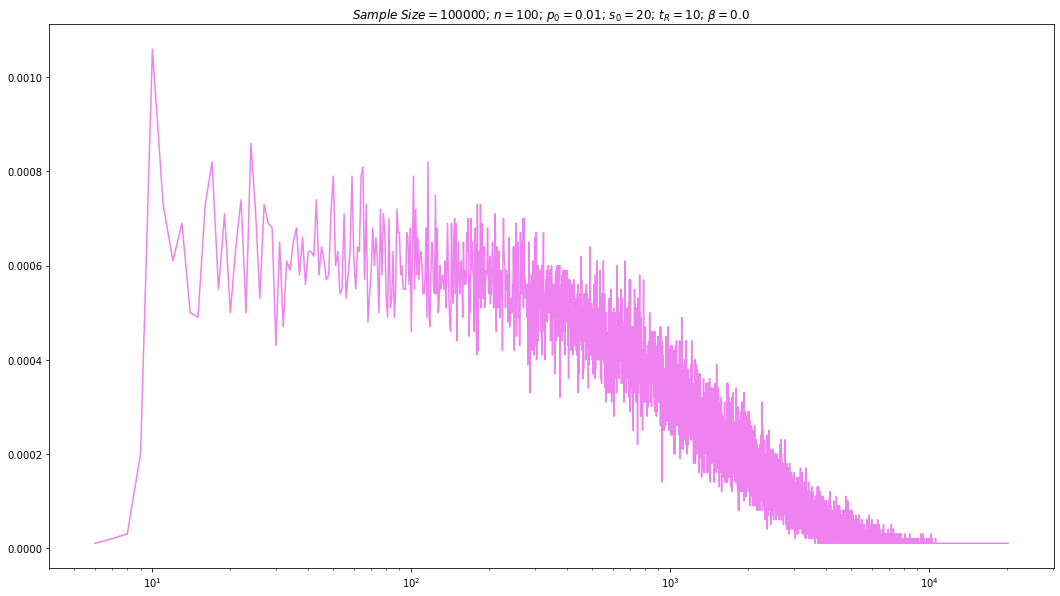

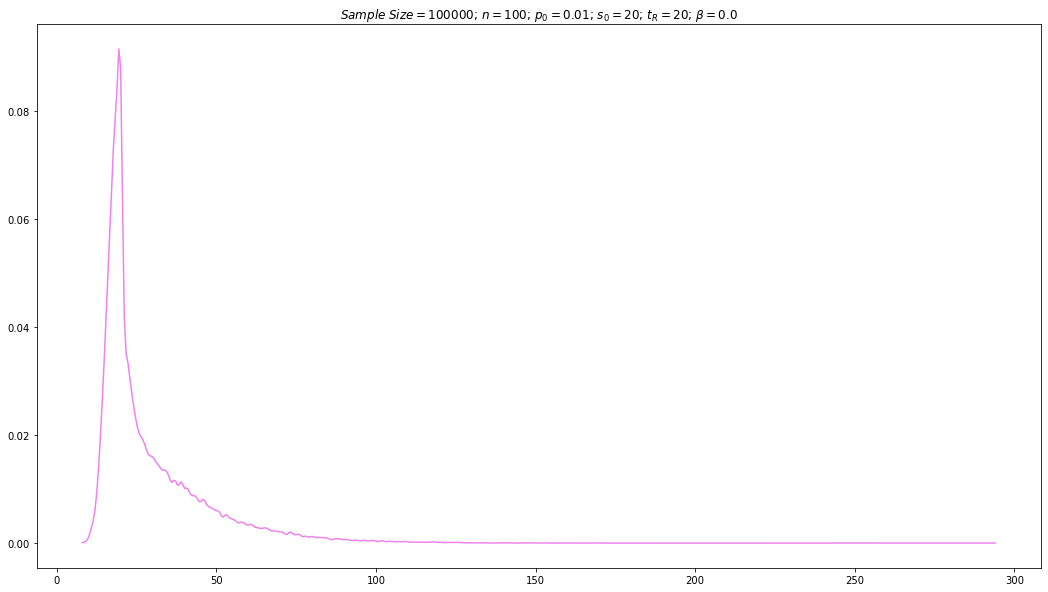

In [20]:
# plt.xlim(x_range)

for sim in demo_sims:
    plt.figure(figsize=(18,10))
    plt.title(fr"$Sample \; Size = {sim['trial_count']}$; $n = {sim['configs']['n']}$; $p_0 = {sim['configs']['p0']}$; $s_0 = {sim['configs']['s0']}$; $t_R = {sim['configs']['tr']}$; $\beta = {sim['configs']['beta']}$")

    interpolate = True
    if max(sim['results']) > 1e3:
        plt.xscale('log')
        interpolate = False

    plot_trial(sim['results'], label=f"Simulation", linestyle="-", color="violet", interpolate=interpolate)
    plt.show()